# How Education Affects Crime in Baltimore, MD
### <i> Daniel Choo & Adrianne Santinor </i>

<p>For this project, we decided to see if there was any significant relationship between libraries in Baltimore and any victim-based crimes that occur in each branch's area. We used the following datasets from <a href="https://data.baltimorecity.gov/">OpenBaltimore</a>:
    <ul>
        <li><strong>Libraries</strong>: this data set shows the location of Baltimore City public libraries listed on the Enoch Pratt Library website.</li>
        <li><strong>BPD Part 1 Victim Based Crime Data</strong>: this data set shows all victim-based data reported by the Baltimore Police department from 2014 to April 20<sup>th</sup>, 2019</li>
    </ul>
</p>

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

lib = pd.read_csv('Libraries.csv')
crime = pd.read_csv('BPD_Part_1_Victim_Based_Crime_Data.csv')
lib.head()

,name,zipCode,neighborhood,councilDistrict,policeDistrict,Location 1,2010 Census Neighborhoods,2010 Census Wards Precincts,Zip Codes
0,Central,21201,Downtown,11,CENTRAL,"400 Cathedral St\nBaltimore, MD",NaN,NaN,NaN
1,Brooklyn,21225,Brooklyn,10,SOUTHERN,"300 Patapsco Av\nBaltimore, MD",NaN,NaN,NaN
2,Canton,21224,Canton,1,SOUTHEASTERN,"1030 Ellwood St\nBaltimore, MD",NaN,NaN,NaN
3,Cherry Hill,21225,Cherry Hill,10,SOUTHERN,"606 Cherry Hill\nBaltimore, MD",NaN,NaN,NaN
4,Clifton,21213,South Clifton Park,12,EASTERN,"2001 Wolfe St\nBaltimore, MD",NaN,NaN,NaN


In [48]:
crime.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,crimeCaseNumber,Total Incidents
0,04/20/2019,9:50:00 PM,6D,MILTON AV & E BALTIMORE ST,LARCENY FROM AUTO,NaN,NaN,222.0,SOUTHEASTERN,Patterson Place,-76.58188,39.29200,NaN,NaN,NaN,1
1,04/20/2019,9:23:00 AM,4E,2100 CRIMEA RD,COMMON ASSAULT,I,NaN,821.0,SOUTHWESTERN,Wakefield,-76.70306,39.31018,NaN,ROW/TOWNHOUSE-OCC,NaN,1
2,04/20/2019,9:20:00 AM,6D,2700 LIGHTHOUSE PT E,LARCENY FROM AUTO,I,NaN,232.0,SOUTHEASTERN,Canton,-76.57800,39.27800,NaN,OTHER - INSIDE,NaN,1
3,04/20/2019,9:00:00 AM,4C,3500 W BELVEDERE AVE,AGG. ASSAULT,O,OTHER,614.0,NORTHWESTERN,Central Park Heights,-76.67907,39.34690,NaN,STREET,NaN,1
4,04/20/2019,9:00:00 AM,4C,3500 W BELVEDERE AVE,AGG. ASSAULT,O,OTHER,614.0,NORTHWESTERN,Central Park Heights,-76.67907,39.34690,NaN,STREET,NaN,1


The only attributes we're interested in right now are the following:
- Description (crime)
- District (crime)
- Total Incidents (crime)
- name (lib)
- policeDistrict (lib)

So we remove any other columns from their respective datasets.

In [49]:
crime = crime.drop(['CrimeDate', 'CrimeTime', 'CrimeCode', 'Location 1', 'Inside/Outside', 'Weapon', 'Post', 'Neighborhood', 'Longitude', 'Latitude', 'Location', 'Premise', 'crimeCaseNumber', 'Total Incidents'], axis=1)
lib = lib.drop(['zipCode', 'neighborhood', 'councilDistrict', 'Location 1', '2010 Census Neighborhoods', '2010 Census Wards Precincts', 'Zip Codes'], axis=1)

In [50]:
lib.head()

,name,policeDistrict
0,Central,CENTRAL
1,Brooklyn,SOUTHERN
2,Canton,SOUTHEASTERN
3,Cherry Hill,SOUTHERN
4,Clifton,EASTERN


In [51]:
crime.head()

,Description,District
0,LARCENY FROM AUTO,SOUTHEASTERN
1,COMMON ASSAULT,SOUTHWESTERN
2,LARCENY FROM AUTO,SOUTHEASTERN
3,AGG. ASSAULT,NORTHWESTERN
4,AGG. ASSAULT,NORTHWESTERN


In [52]:
# determining whether there are any missing values in any columns and cleaning if necessary
missingCrime = crime['District'].isna().any()
missingLib = lib['policeDistrict'].isna().any()

if missingCrime:
    print("Missing values in Victim Based Crime dataset.\nRemoving those instances now.")
    crime = crime.dropna(subset=['District'])
    
if missingLib:
    print("Missing values in Libraries dataset.\nRemoving those instances now.")
    lib = lib.dropna(subset=['policeDistrict'])

Missing values in Victim Based Crime dataset.
Removing those instances now.


Now that the data is clean, we can create a table that combines all this information

In [60]:
# creates a dictionary with districts as the keys and library count as the values
dictLib = {}

for row in lib.itertuples(index=False):
    if (row[1] in dictLib) and (dictLib.get(row[1]) >= 1):
        dictLib[row[1]] = dictLib.get(row[1]) + 1
    else:
        dictLib[row[1]] = 1

# have to hardcode districts because value_counts() only returns a Series which is one-dimensional :/
crimeDist = ['NORTHEASTERN', 'SOUTHEASTERN', 'SOUTHERN', 'CENTRAL', 'NORTHERN', 'SOUTHWESTERN', 'NORTHWESTERN', 'EASTERN', 'WESTERN']

# create a dataframe
allCrimes = pd.DataFrame(crime['District'].value_counts(), index=crimeDist)
allCrimes.columns = ['allCrimes']

# function that assigns a crime to the district it occurred in, in the order that allCrimes is indexed
def make_col(cDist, cMap):
    i = 0
    for dist in cMap:
        cDist[i] = cMap.get(allCrimes.index[i])
        i += 1

# filter by types of crimes
larc = crime.query('Description == \'LARCENY\'')
cass = crime.query('Description == \'COMMON ASSAULT\'')
burg = crime.query('Description == \'BURGLARY\'')
alarc = crime.query('Description == \'LARCENY FROM AUTO\'')
aagg = crime.query('Description == \'AGG. ASSAULT\'')
athft = crime.query('Description == \'AUTO THEFT\'')
srob = crime.query('Description == \'ROBBERY - STREET\'')
crob = crime.query('Description == \'ROBBERY - COMMERCIAL\'')
sht = crime.query('Description == \'SHOOTING\'')
rrob = crime.query('Description == \'ROBBERY - RESIDENCE\'')
carob = crime.query('Description == \'ROBBERY - CARJACKING\'')
rp = crime.query('Description == \'RAPE\'')
ho = crime.query('Description == \'HOMICIDE\'')
ar = crime.query('Description == \'ARSON\'')

# get_values() returns a series in descending chronological order, which is different for each crime so this is what we gotta do
larcDist = ['SOUTHEASTERN', 'CENTRAL', 'NORTHEASTERN', 'NORTHERN', 'SOUTHERN', 'NORTHWESTERN', 'SOUTHWESTERN', 'EASTERN', 'WESTERN']
cassDist = ['NORTHEASTERN', 'SOUTHEASTERN', 'CENTRAL', 'EASTERN', 'SOUTHWESTERN', 'SOUTHERN', 'WESTERN', 'NORTHWESTERN', 'NORTHERN']
burgDist = ['NORTHEASTERN', 'NORTHERN', 'SOUTHEASTERN', 'SOUTHERN', 'SOUTHWESTERN', 'NORTHWESTERN', 'EASTERN', 'CENTRAL', 'WESTERN']
alarcDist = ['SOUTHEASTERN', 'NORTHEASTERN', 'CENTRAL', 'NORTHERN', 'SOUTHERN', 'NORTHWESTERN', 'EASTERN', 'SOUTHWESTERN', 'WESTERN']
aaggDist = ['NORTHEASTERN', 'SOUTHERN', 'WESTERN', 'SOUTHWESTERN', 'EASTERN', 'SOUTHEASTERN', 'NORTHWESTERN', 'CENTRAL', 'NORTHERN']
athftDist = ['NORTHEASTERN','NORTHWESTERN','SOUTHWESTERN','SOUTHERN','SOUTHEASTERN','WESTERN','NORTHERN','EASTERN','CENTRAL']
srobDist = ['SOUTHEASTERN', 'NORTHEASTERN','CENTRAL','NORTHERN','SOUTHERN','NORTHWESTERN','EASTERN','SOUTHWESTERN','WESTERN']
crobDist = ['NORTHEASTERN','SOUTHEASTERN','NORTHERN','CENTRAL','SOUTHERN','NORTHWESTERN','SOUTHWESTERN','EASTERN','WESTERN']
shtDist = ['WESTERN','EASTERN','SOUTHWESTERN','SOUTHERN','NORTHWESTERN','NORTHEASTERN','NORTHERN','CENTRAL','SOUTHEASTERN']
rrobDist = ['NORTHEASTERN','SOUTHERN','SOUTHWESTERN','SOUTHEASTERN','NORTHWESTERN','NORTHERN','EASTERN','WESTERN','CENTRAL']
carobDist = ['NORTHWESTERN','NORTHEASTERN','SOUTHERN','SOUTHWESTERN','WESTERN','NORTHERN','SOUTHEASTERN','CENTRAL','EASTERN']
rpDist = ['NORTHEASTERN','SOUTHERN','CENTRAL','NORTHERN','SOUTHWESTERN','EASTERN','SOUTHEASTERN','NORTHWESTERN','WESTERN']
hoDist = ['WESTERN','EASTERN','SOUTHWESTERN','NORTHWESTERN','NORTHEASTERN','SOUTHERN','NORTHERN','CENTRAL','SOUTHEASTERN']
arDist = ['NORTHEASTERN','NORTHWESTERN','SOUTHWESTERN','SOUTHERN','EASTERN','WESTERN','NORTHERN','SOUTHEASTERN','CENTRAL']

# initializing dictionaries that assigns crime frequencies to their respective districts
larcMap = {}
cassMap = {}
burgMap = {}
alarcMap = {}
aaggMap = {}
athftMap = {}
srobMap = {}
crobMap = {}
shtMap = {}
rrobMap = {}
carobMap = {}
rpMap = {}
hoMap = {}
arMap = {}

# assigning each crime frequency to their respective districts, in the relative order of the crime's frequency
for i in range(0,9):
    larcMap[larcDist[i]] = larc['District'].value_counts()[i]
    cassMap[cassDist[i]] = cass['District'].value_counts()[i]
    burgMap[burgDist[i]] = burg['District'].value_counts()[i]
    alarcMap[alarcDist[i]] = alarc['District'].value_counts()[i]
    aaggMap[aaggDist[i]] = aagg['District'].value_counts()[i]
    athftMap[athftDist[i]] = athft['District'].value_counts()[i]
    srobMap[srobDist[i]] = srob['District'].value_counts()[i]
    crobMap[crobDist[i]] = crob['District'].value_counts()[i]
    shtMap[shtDist[i]] = sht['District'].value_counts()[i]
    rrobMap[rrobDist[i]] = rrob['District'].value_counts()[i]
    carobMap[carobDist[i]] = carob['District'].value_counts()[i]
    rpMap[rpDist[i]] = rp['District'].value_counts()[i]
    hoMap[hoDist[i]] = ho['District'].value_counts()[i]
    arMap[arDist[i]] = ar['District'].value_counts()[i]
    
# normalizes indexing so everything matches with allCrime's index
make_col(larcDist, larcMap)
make_col(cassDist, cassMap)
make_col(burgDist, burgMap)
make_col(alarcDist, alarcMap)
make_col(aaggDist, aaggMap)
make_col(athftDist, athftMap)
make_col(srobDist, srobMap)
make_col(crobDist, crobMap)
make_col(shtDist, shtMap)
make_col(rrobDist, rrobMap)
make_col(carobDist, carobMap)
make_col(rpDist, rpMap)
make_col(hoDist, hoMap)
make_col(arDist, arMap)

# adding columns to dataframe
allCrimes['Larceny'] = larcDist
allCrimes['Common Assault'] = cassDist
allCrimes['Burglary'] = burgDist
allCrimes['Larceny from Auto'] = alarcDist
allCrimes['Agg. Assault'] = aaggDist
allCrimes['Auto Theft'] = athftDist
allCrimes['Robbery - Street'] = srobDist
allCrimes['Robbery - Commercial'] = crobDist
allCrimes['Shooting'] = shtDist
allCrimes['Robbery - Residence'] = rrobDist
allCrimes['Robbery - Carjacking'] = carobDist
allCrimes['Rape'] = rpDist
allCrimes['Homicide'] = hoDist
allCrimes['Arson'] = arDist

# adding library count as a column
libDist = []
i = 0
for libs in dictLib:
    libDist.append(dictLib.get(allCrimes.index[i]))
    i+=1

# need to manually add 0 to represent number of libraries in western
# so that array length matches allCrimes index length
libDist.append(0)

allCrimes['Library Count'] = libDist
allCrimes

,allCrimes,Larceny,Common Assault,Burglary,Larceny from Auto,Agg. Assault,Auto Theft,Robbery - Street,Robbery - Commercial,Shooting,Robbery - Residence,Robbery - Carjacking,Rape,Homicide,Arson,Library Count
NORTHEASTERN,38509,7854,6097,6520,4947,3606,4357,2711,747,306,484,271,215,173,221,3
SOUTHEASTERN,36562,9074,5332,4909,6957,3094,2383,3146,672,172,283,206,162,88,84,4
SOUTHERN,29298,6574,4489,4872,3563,3310,2542,1988,518,340,382,243,192,131,154,4
CENTRAL,28510,8039,4904,2786,4728,2599,1455,2529,575,192,183,180,187,90,63,2
NORTHERN,28445,6951,3567,5114,4631,2217,2242,2030,635,197,261,221,180,94,105,4
SOUTHWESTERN,25601,5092,4567,4160,2515,3168,2893,1331,408,408,285,234,179,199,162,2
NORTHWESTERN,25106,5329,3714,4012,2843,2673,3042,1597,489,329,276,300,160,174,168,2
EASTERN,21974,4185,4645,2804,2540,3098,1665,1436,319,424,235,133,163,207,120,1
WESTERN,20117,3654,3987,2636,1543,3182,2250,1169,246,500,228,234,142,237,109,0


{NOTES TO FUTURE DANIEL AND ADRIANNE}
- create graphs!!!

In [24]:
# Exporting to CSV so we can use this dataset for Weka.
allCrimes.to_csv("allcrimes.csv")

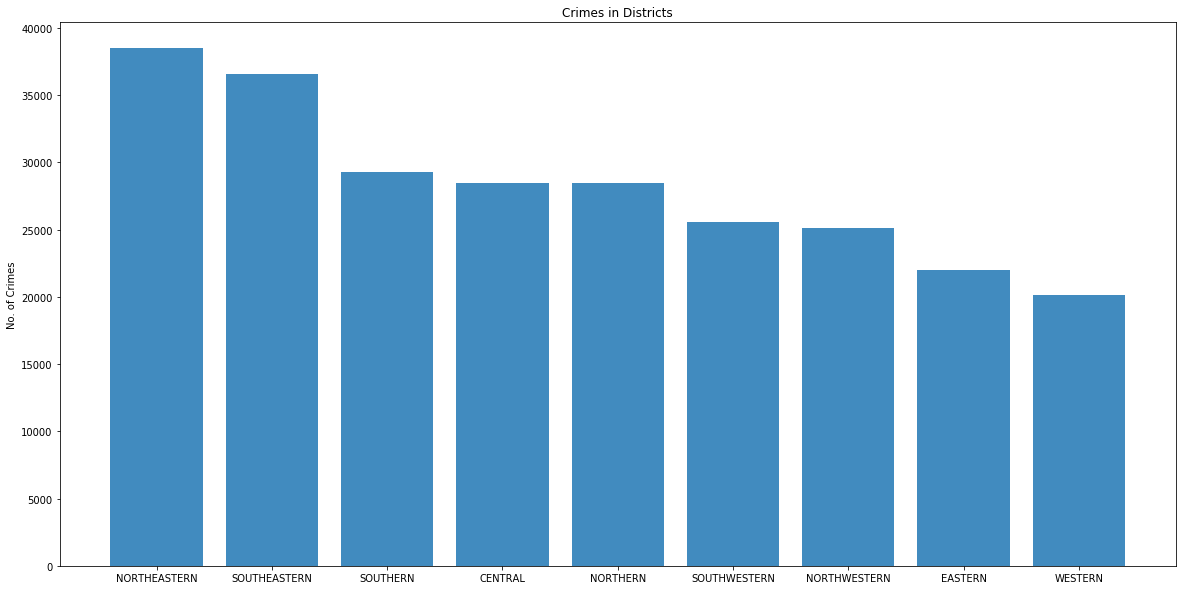

In [61]:
# Creating a bar graph to show all the crimes in each district
plt.figure(figsize=(20,10))
pos = np.arange(len(crimeDist))

plt.bar(pos, allCrimes['allCrimes'], align='center', alpha=0.85)
plt.xticks(pos, crimeDist)
plt.ylabel('No. of Crimes')
plt.title('Crimes in Districts')

plt.show()

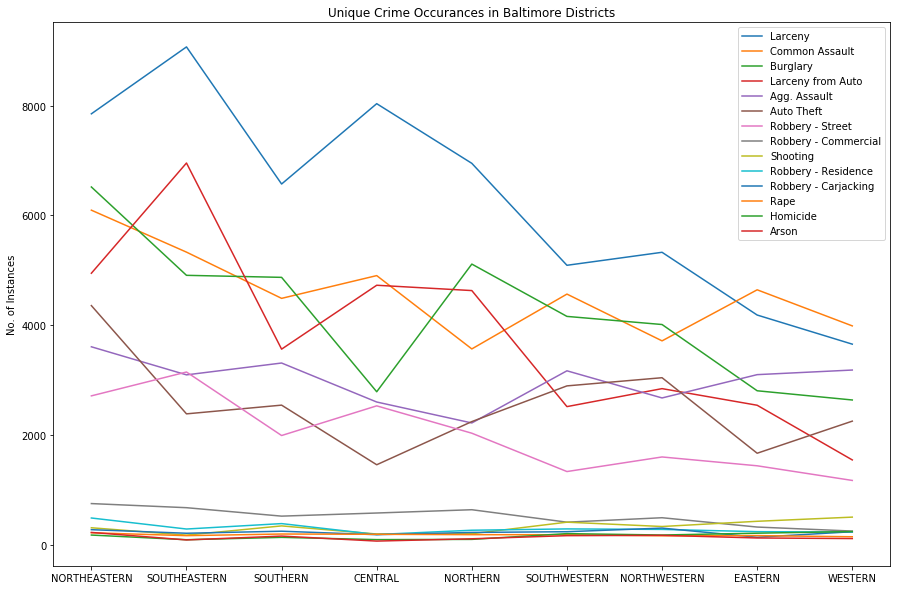

In [69]:
# Creating a multi-line graph to demonstrate trends in crimes in each district.
plt.figure(figsize=(15,10))
plt.plot(allCrimes['Larceny'])
plt.plot(allCrimes['Common Assault'])
plt.plot(allCrimes['Burglary'])
plt.plot(allCrimes['Larceny from Auto'])
plt.plot(allCrimes['Agg. Assault'])
plt.plot(allCrimes['Auto Theft'])
plt.plot(allCrimes['Robbery - Street'])
plt.plot(allCrimes['Robbery - Commercial'])
plt.plot(allCrimes['Shooting'])
plt.plot(allCrimes['Robbery - Residence'])
plt.plot(allCrimes['Robbery - Carjacking'])
plt.plot(allCrimes['Rape'])
plt.plot(allCrimes['Homicide'])
plt.plot(allCrimes['Arson'])
plt.ylabel('No. of Instances')
plt.title('Unique Crime Occurances in Baltimore Districts')
plt.legend()